# Plot Eval metrics

In [71]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import joblib
import re
import seaborn as sns
from typing import Callable
from matplotlib.patches import Rectangle
import matplotlib as mpl
import numpy as np
# Apply the default theme
# sns.set_theme()
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 150

import sys

sys.path.append("..")

from src.data.dataloader import PromptLoader, GigawordDataLoader, DailymailDataLoader, TweetQADataLoader, RottenTomatoesDataLoader
from src.utils.eval_metric import eval_gigaword, eval_dailymail, evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

load_dotenv()

True

In [72]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [73]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [74]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 4)
print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
}

# Assign linestyle to model
model_linestyle = {
    "mistral-7b": "-",
    "llama-7b": "--",
}

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]


In [75]:
def plot_dataset_models_legend(ax: plt.axes):
    """Create a tabular legend: rows are datasets, columns are models"""
    # create blank rectangle as a placeholder
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor="none", linewidth=0)

    # Top left corner of legend is blank
    legend_handles = [extra]
    legend_labels = [""]

    # First column is list of datasets
    for dataset in dataset_color.keys():
        legend_handles.append(extra)
        legend_labels.append(dataset)

    # Subsequent columns are for each model
    for model, style in model_linestyle.items():
        # Model name
        legend_handles.append(extra)
        legend_labels.append(model)
        for dataset, colour in dataset_color.items():
            (im,) = ax.plot([], [], linestyle=style, color=colour, marker="x")
            # Add line style to legend
            legend_handles.append(im)
            legend_labels.append("")

    ax.legend(
        legend_handles,
        legend_labels,
        ncols=len(model_linestyle) + 1,
        loc="upper left",
        bbox_to_anchor=(0, 1.5),
        handletextpad=-2,
    )

In [76]:
def plot_df_metrics(
    results_df: pd.DataFrame,
    metrics: list[str],
    save_path: Path = None,
    title: str = None,
    adjust_func: Callable = lambda _: _,
):
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    num_metrics = len(metrics)
    fig, axs = plt.subplots(
        figsize=(10, 4 * num_metrics), nrows=num_metrics, ncols=1, sharex=True
    )
    for idx, (metric, ax) in enumerate(zip(metrics, axs)):
        for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
            df = df.sort_values("num_examples")

            g = sns.lineplot(
                data=df,
                x="num_examples",
                y=metric,
                ax=ax,
                label=f"{model} {inctxt}",
                linestyle=model_linestyle[model],
                color=dataset_color[inctxt],
                marker="X",
            )
            ax.set_ylabel(metric)
            # Remove legend for all but last plot
            # if idx != num_metrics - 1:
                # ax.legend_.remove()
            ax.legend_.remove()

    # Add legend
    plot_dataset_models_legend(axs[0])

    axs[-1].set_xlabel("Number of examples")
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    adjust_func(axs)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        # Also save as png
        plt.savefig(save_path.with_suffix(".png"), bbox_inches="tight")
    plt.show()

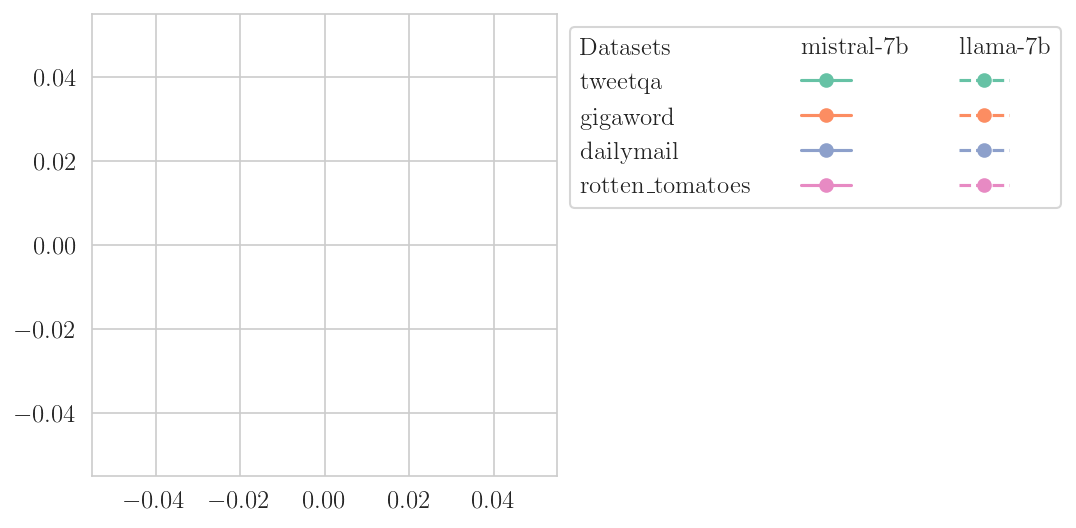

In [77]:
fig, ax = plt.subplots(figsize=(4, 4))

# create blank rectangle
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor="none", linewidth=0)

# rows as datasets, columns as models
legend_handles = [extra]
legend_labels = ["Datasets"]

# First column is list of datasets
for dataset in dataset_color.keys():
    legend_handles.append(extra)
    legend_labels.append(dataset)

# Subsequent columns are for each model
for model, style in model_linestyle.items():
    # Model name
    legend_handles.append(extra)
    legend_labels.append(model)
    for dataset, colour in dataset_color.items():
        (im,) = ax.plot([], [], linestyle=style, color=colour, marker="o")
        legend_handles.append(im)
        legend_labels.append("")

ax.legend(
    legend_handles,
    legend_labels,
    ncols=3,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    handletextpad=-2,
)
plt.show()

## Evaluate on Rotten Tomatoes

In [78]:
rt = RottenTomatoesDataLoader()
rt_reference_data = rt.load_test_reference()
rt_results = get_results_for_evalset("rotten_tomatoes", rt_reference_data, use_cached=True)
rt_results_df = pd.DataFrame.from_records(rt_results)
rt_results_df.head()

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_rotten_tomatoes/incontext_data_dailymail/num_examples_8


,matches,failed,total,model,incontext_set,num_examples
0,924,1,1066,mistral-7b,dailymail,0
1,892,1,1066,mistral-7b,dailymail,4
2,898,2,1066,mistral-7b,dailymail,2
3,970,0,1066,mistral-7b,rotten_tomatoes,10
4,959,2,1066,mistral-7b,rotten_tomatoes,6


In [79]:
# Remove llama dailymail num examples 4
# rt_results_df = rt_results_df[
#     ~((rt_results_df["model"] == "llama-7b") & (rt_results_df["num_examples"] == 4) & (rt_results_df["incontext_set"] == "dailymail"))
# ]

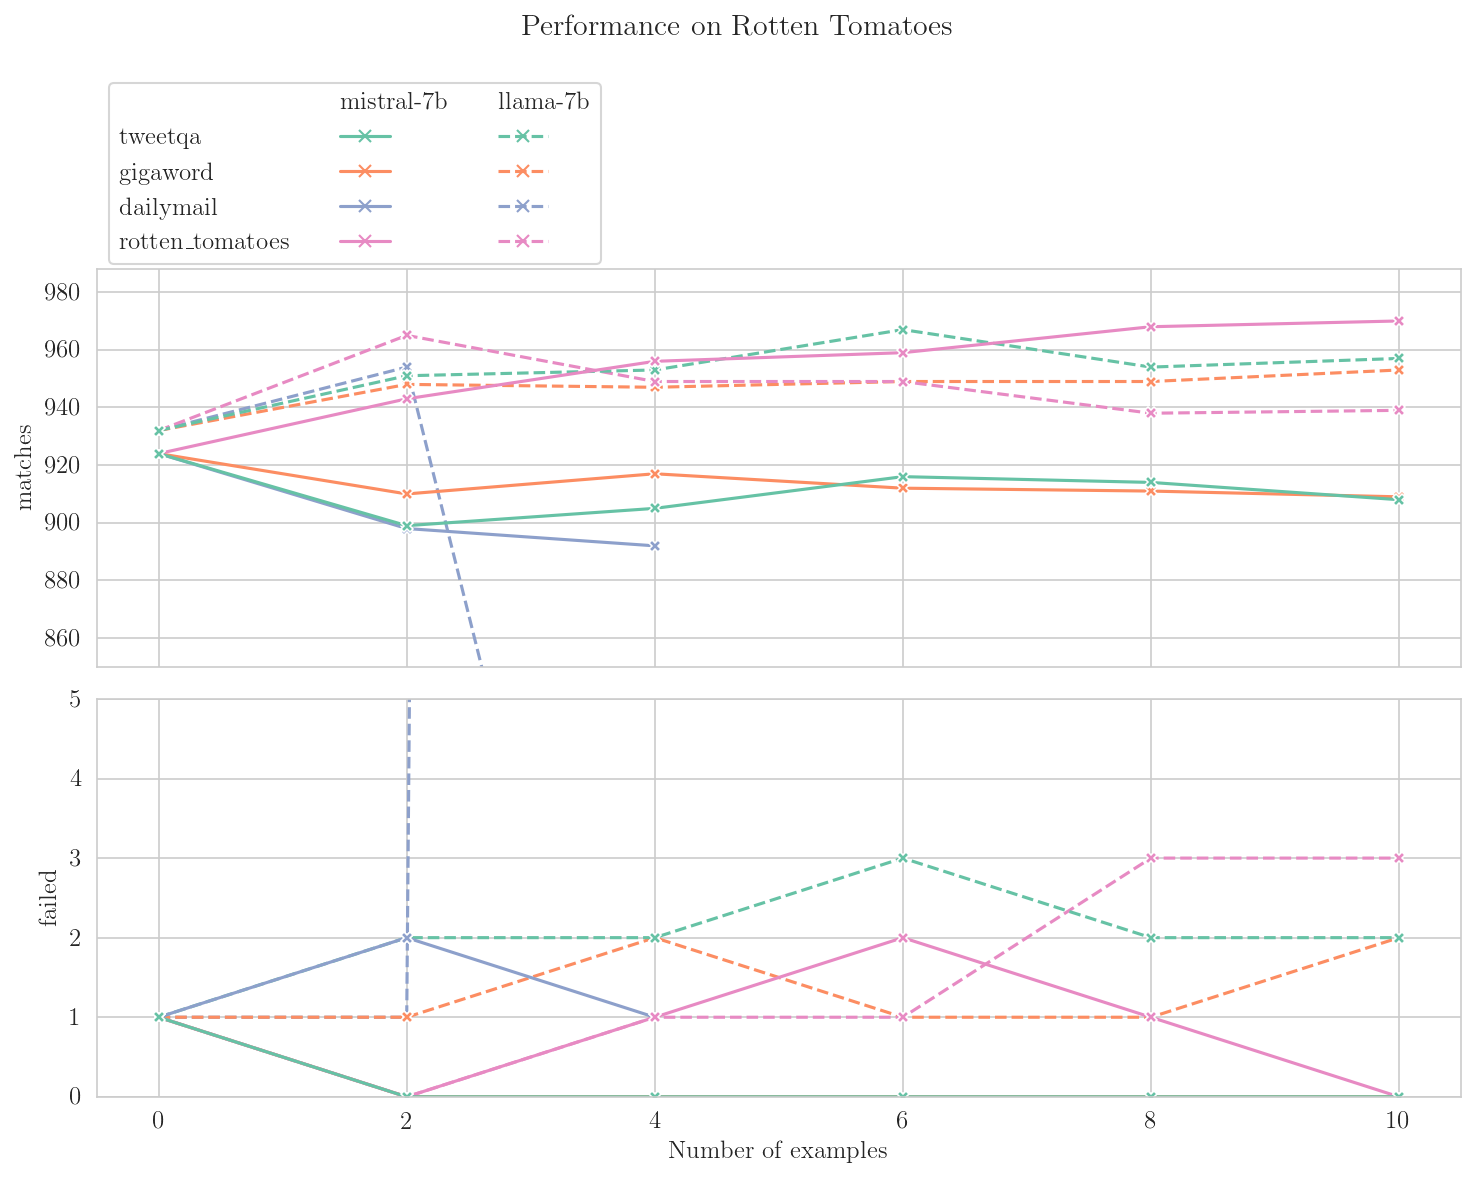

In [80]:
plot_df_metrics(
    rt_results_df,
    ["matches", "failed"],
    save_path=Path("rt_eval.pdf"),
    title="Performance on Rotten Tomatoes",
    adjust_func=lambda axs: (
        axs[0].set_ylim(850, None),
        axs[1].set_ylim(0, 5),
    ),
)

## Evaluate on TweetQA

In [81]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()
tq_results = get_results_for_evalset("tweetqa", tq_reference_data, use_cached=True)
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")
tq_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_5
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/nu

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples
0,0.280516,0.146597,0.277659,0.277374,0.427295,mistral-7b,dailymail,3
1,0.253490,0.126177,0.249727,0.250292,0.407057,mistral-7b,dailymail,0
2,0.281016,0.145278,0.278097,0.278325,0.425253,mistral-7b,dailymail,4
3,0.285133,0.145719,0.281766,0.281789,0.429017,mistral-7b,dailymail,2
4,0.280501,0.141212,0.277623,0.277247,0.426147,mistral-7b,dailymail,5


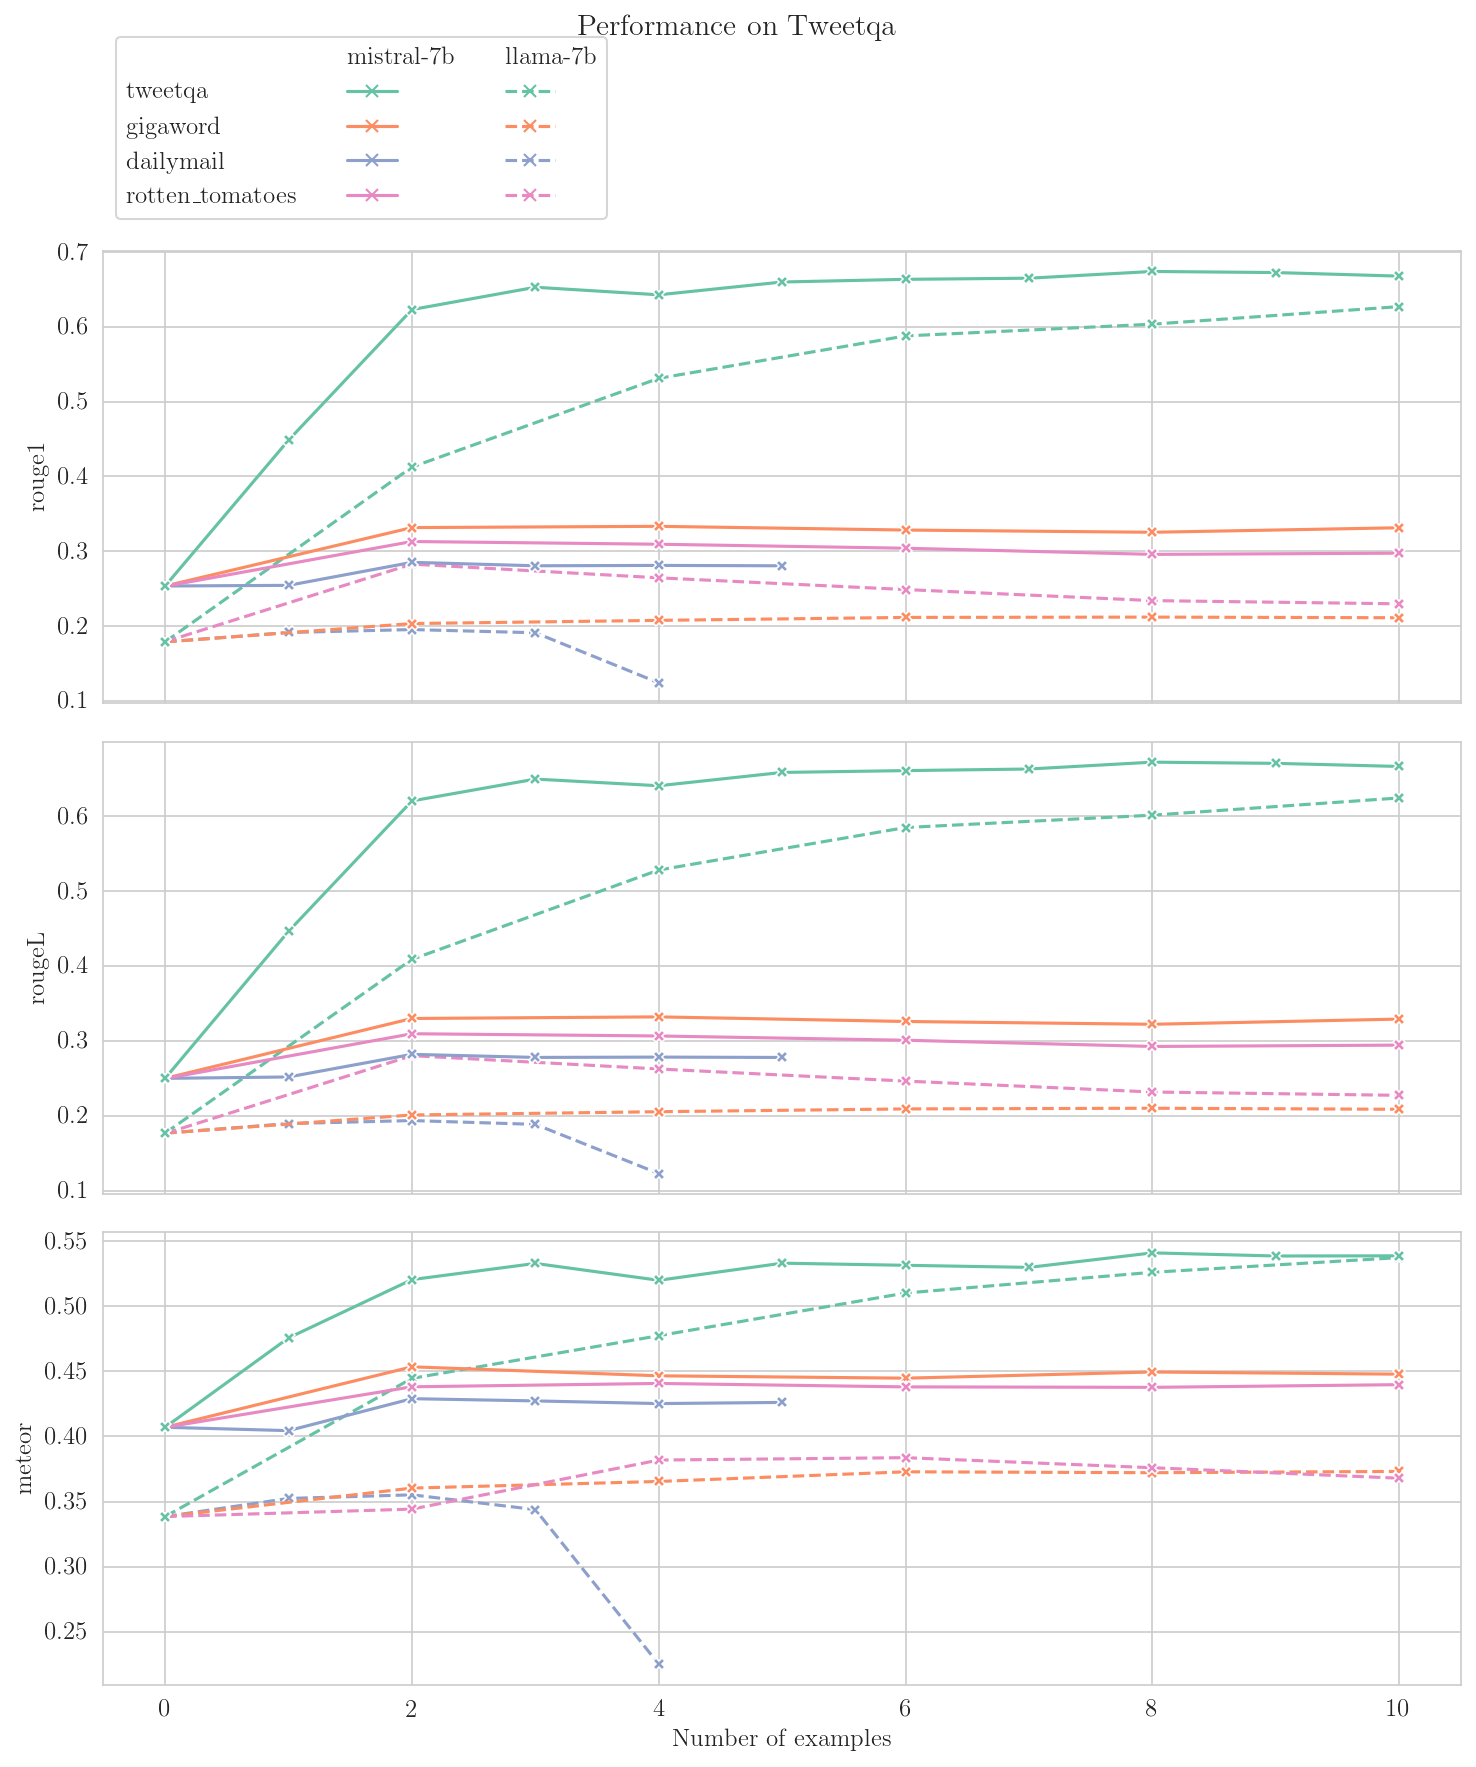

In [82]:
plot_df_metrics(
    tq_results_df,
    ["rouge1", "rougeL", "meteor"],
    save_path=Path("tweetqa_eval.pdf"),
    title="Performance on Tweetqa"
)

## Evaluate on Dailymail Set

In [83]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()
dm_results = get_results_for_evalset("dailymail", dm_reference_data, use_cached=True)
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()


Removing large training set examples
Original training set size:  287113
New Training set size:  258269
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_dail

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.093224,0.003662,0.067809,0.080595,813.963,mistral-7b,dailymail,3
1,0.093699,0.003405,0.069112,0.081602,881.994,mistral-7b,dailymail,6
2,0.091363,0.003634,0.067305,0.078851,778.065,mistral-7b,dailymail,0
3,0.093627,0.003601,0.068690,0.081612,887.419,mistral-7b,dailymail,4
4,0.091660,0.003621,0.067545,0.079598,909.117,mistral-7b,dailymail,2


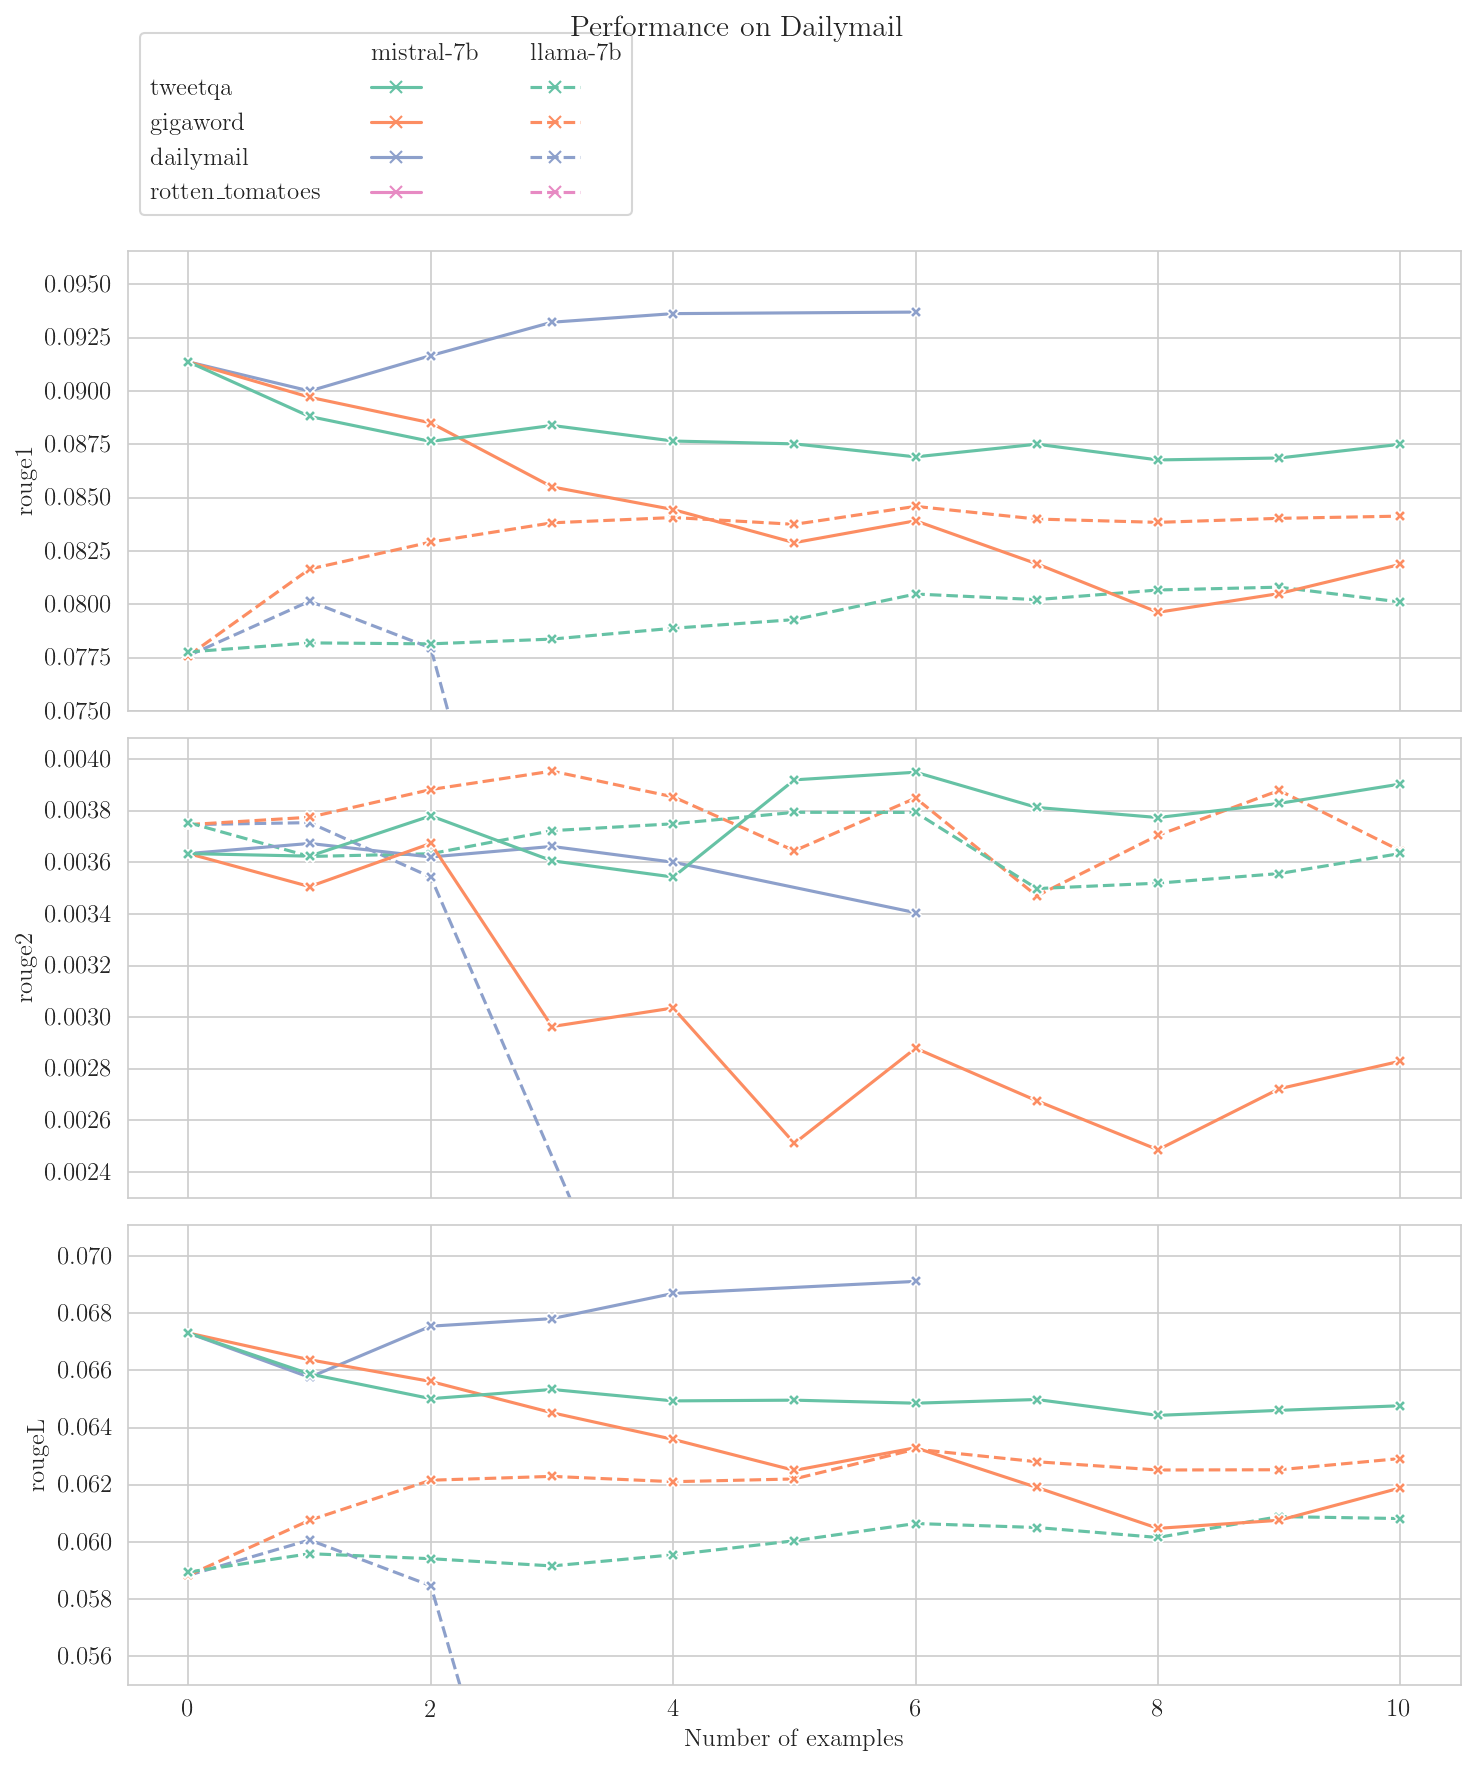

In [84]:
plot_df_metrics(
    dm_results_df,
    ["rouge1", "rouge2", "rougeL"],
    save_path=Path("dailymail_eval.pdf"),
    title="Performance on Dailymail",
    adjust_func=lambda axs: (
        axs[0].set_ylim(0.075, None),
        axs[1].set_ylim(0.0023, None),
        axs[2].set_ylim(0.055, None),
    ),
)

## Gigaword set

In [85]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()
gw_results = get_results_for_evalset("gigaword", gw_reference_data, use_cached=True)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_4
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_gigaword/num_examples_15
Skipping ../experiments/llama-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_gigaword/in

In [86]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))
gw_results_df.head()

50


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.208261,0.064304,0.181171,0.180963,176.746797,mistral-7b,dailymail,3
1,0.185863,0.052018,0.158450,0.158119,203.721681,mistral-7b,dailymail,0
2,0.209927,0.065318,0.182710,0.182371,172.145054,mistral-7b,dailymail,4
3,0.206545,0.064249,0.179086,0.178854,177.343414,mistral-7b,dailymail,2
4,0.211281,0.066499,0.184118,0.183837,169.700666,mistral-7b,dailymail,5


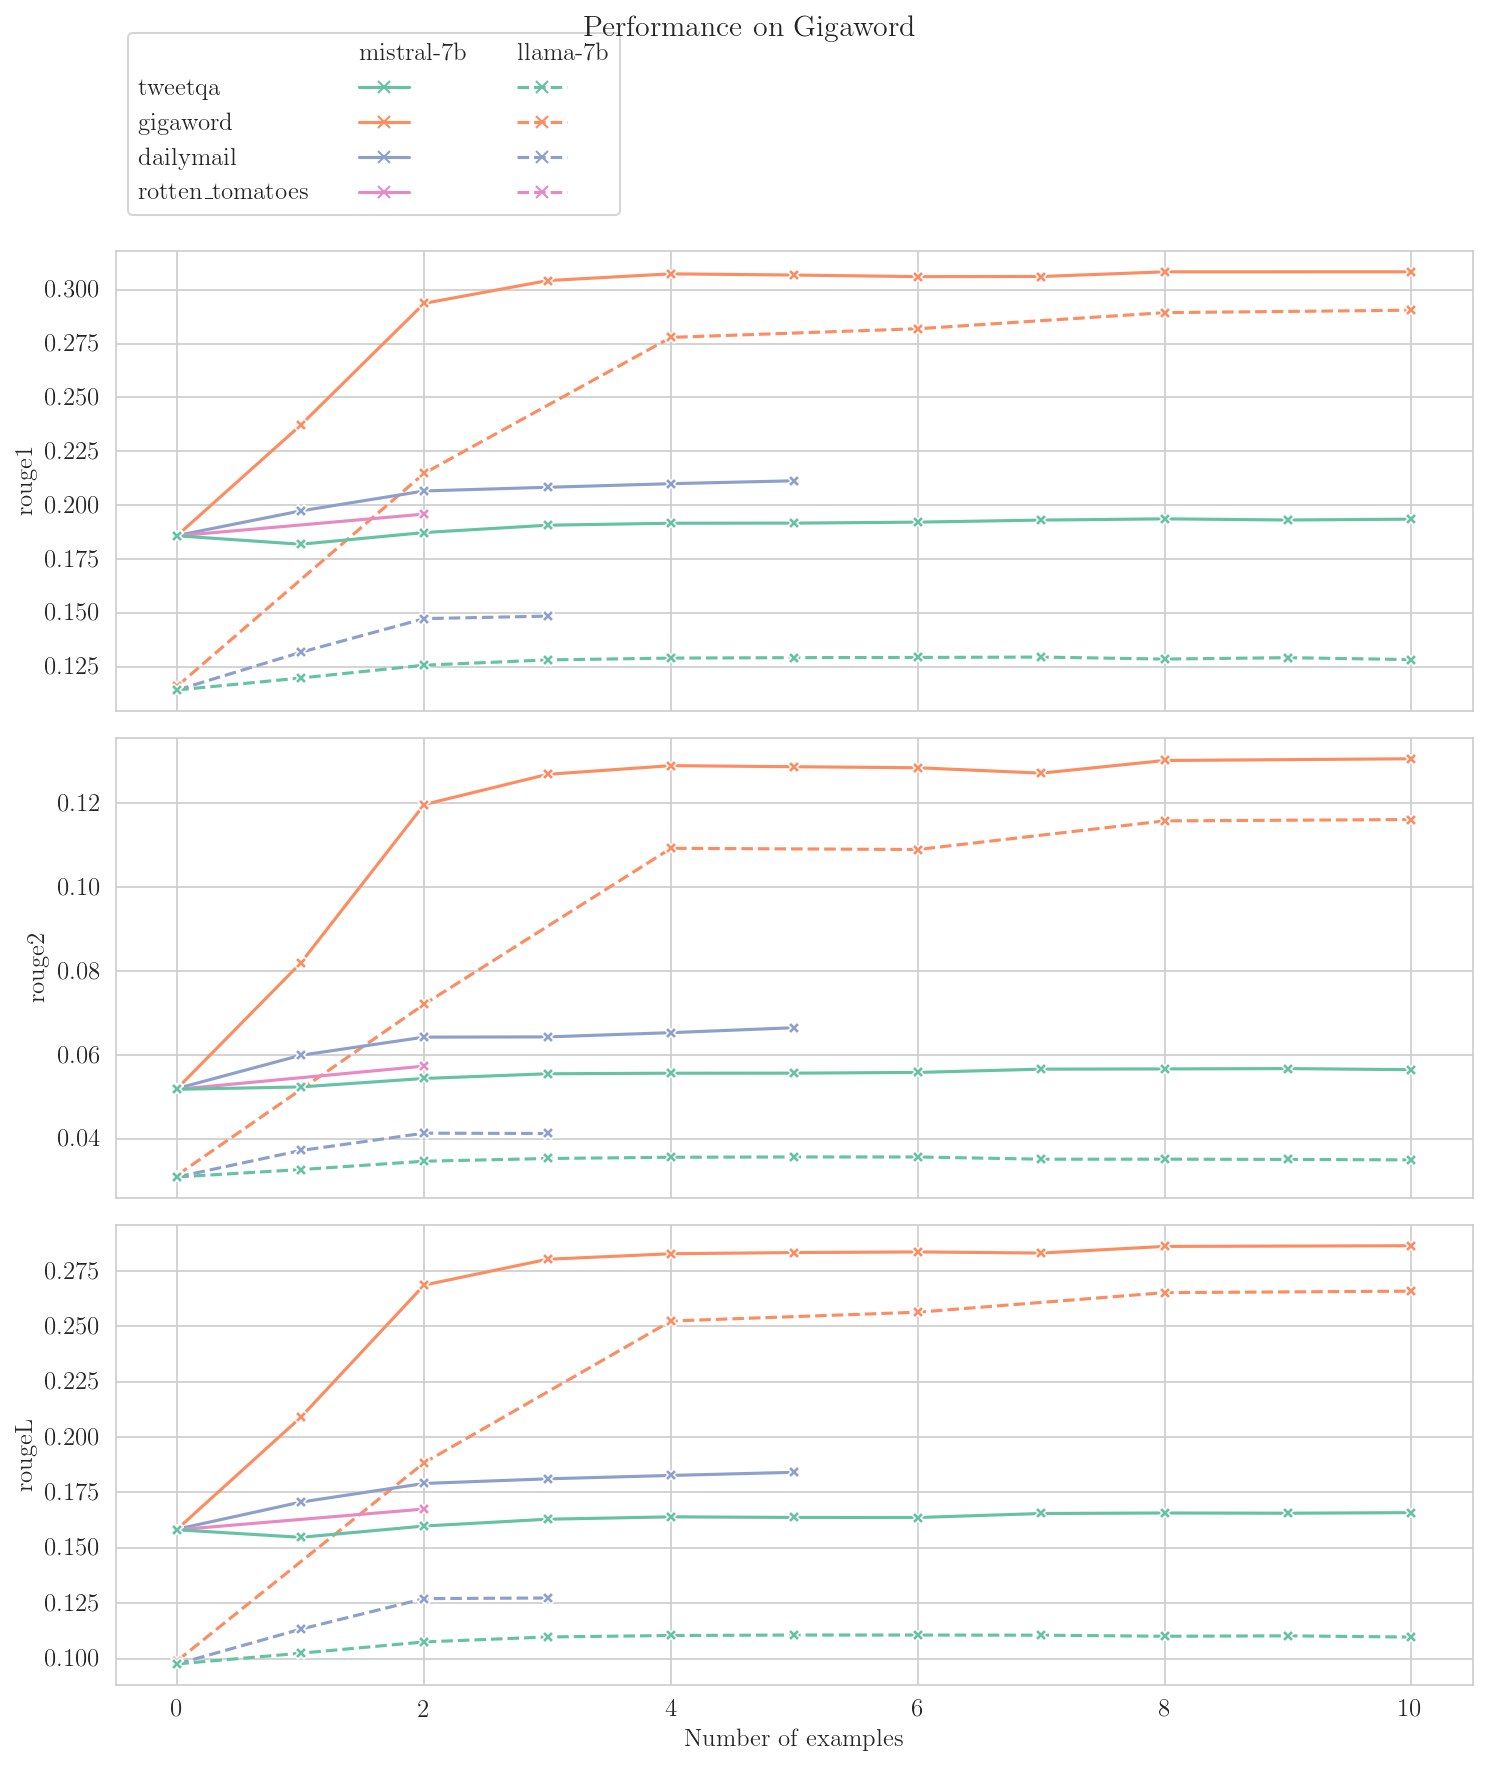

In [87]:
plot_df_metrics(
    gw_results_df,
    ["rouge1", "rouge2", "rougeL"],
    save_path=Path("gigaword_eval.pdf"),
    title="Performance on Gigaword"
)

## .idea

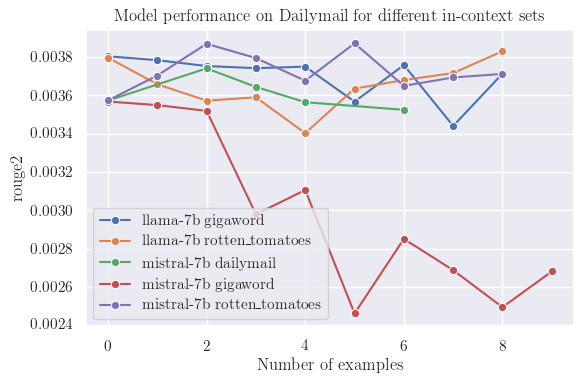

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge2"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

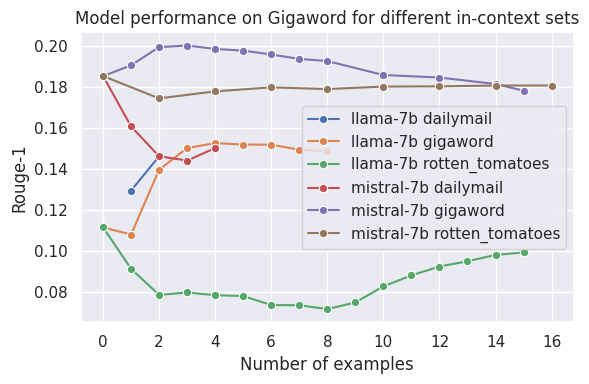

In [13]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

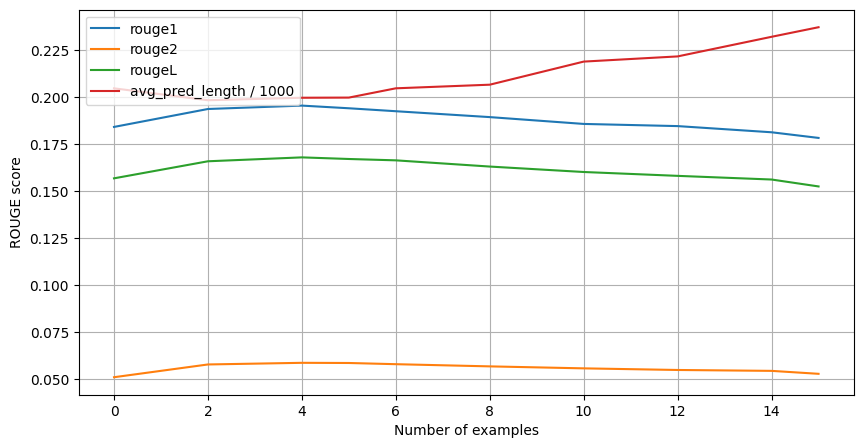

In [56]:
# Plot the results

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["num_examples"], df["rouge1"], label="rouge1")
ax.plot(df["num_examples"], df["rouge2"], label="rouge2")
ax.plot(df["num_examples"], df["rougeL"], label="rougeL")
ax.plot(df["num_examples"], df["avg_pred_length"] / 1000, label="avg_pred_length / 1000")
ax.set_xlabel("Number of examples")
ax.set_ylabel("ROUGE score")
ax.legend()
ax.grid()
fig.savefig("gigaword.png")
plt.show()

### Test evaluate

In [ ]:
pred_path = "/home/ag2118/rds/hpc-work/inctxt/inctxt/experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/predictions.json"

eval_idxs_file = Path(pred_path).parent / "eval_idxs.json"
if eval_idxs_file.is_file():
    ref_data = [dm_reference_data[i] for i in json.load(open(eval_idxs_file))]
else:
    ref_data = dm_reference_data
evaluate(pred_path, ref_data, use_cached=True)